Universidade Federal de Alagoas

IC - Instituto de Computação

# Processamento de linguagem natural - 2020.1

**Professor**: Thales Vieira

**Alunos**: Hugo Tallys Martins Oliveira e Valério Nogueira Rodrigues Júnior

## 3ª lista de exercícios

---

In [1]:
%%html
<style>
    a:link, a:visited {
        color: white;
        font-weight: bold;
        text-decoration: underline;
    }
    code {
        padding: 2px;
        color: blue;
    }
    .w-half {
        width: 50%;
    }
    .left {
        float: left;
    }
    .right {
        float: right;
    }
    .col {
        height: 100%;
        padding-left: 16px;
        padding-right: 16px;
        padding-top: 8px;
        padding-bottom: 8px;

    }
    .better {
        color: white;
        background-color: #5cb85c;
    }
    .worse {
        color: black;
        background-color: ;
    }
</style>

<div style="color: #856404; background-color: #ffeeba; padding: 16px; border: 1px solid transparent; border-radius: .25rem">
    ⚠️ O <code>jupyter</code> deve ser iniciado no diretório que contém a pasta <code>data</code>
</div>

In [2]:
import re
import random

from IPython.core.display import display, HTML
import numpy
import pandas
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Os Dados
Notícias dos sites www.bbc.co.uk (350) e www.cnn.com.br (1275) sobre o novo coronavírus. Cada arquivo contém as seguintes colunas:
- ```url```: Endereço da notícia
- ```title```: Título da notícia
- ```text```: Texto da notícia

As colunas são separadas por `|`

In [3]:
# Carregando dados
bbc = pandas.read_csv('data/bbc.csv', sep='|')
bbc['label'] = 'BBC'
cnn = pandas.read_csv('data/cnn.csv', sep='|')
cnn['label'] = 'CNN'
cnn = cnn.dropna(axis=0)
dataset = pandas.concat([bbc, cnn], ignore_index=True)

# Limpeza
def remove_boilerplate(text):
    boilerplate = ['Compartilhe este post com Email Facebook Messenger Messenger Twitter WhatsApp LinkedIn Copiar este link Estes são links externos e abrirão numa nova janela', 'Já assistiu aos nossos novos vídeos no YouTube? Inscreva-se no nosso canal!', 'Final de YouTube post  de BBC News Brasil Final de YouTube post 2 de BBC News Brasil Final de YouTube post 3 de BBC News Brasil']
    
    for b in boilerplate:
      text = text.replace(b, '')

    return text

dataset.replace(numpy.nan, '', inplace=True)
dataset.text = dataset.text.apply(lambda text: text.replace('\n', ' '))
dataset.text = dataset.text.apply(remove_boilerplate)
dataset.text = dataset.text.apply(lambda text: text.lower().replace('bbc', '').replace('cnn', ''))

dataset.head()

,url,title,text,label
0,https://www.bbc.co.uk/portuguese/brasil-53020785,Coronavírus: pandemia pode jogar até 14 milhõe...,a turbulência econômica causada pela pandemi...,BBC
1,https://www.bbc.co.uk/portuguese/brasil-53027318,Coronavírus: como funcionam as duas vacinas co...,cerca de 11 mil voluntários brasileiros vão ...,BBC
2,https://www.bbc.co.uk/portuguese/brasil-51713943,Coronavírus: Brasil passa o Reino Unido e se t...,*atualizada às 18h20 de 12 de junho de 2020 ...,BBC
3,https://www.bbc.co.uk/portuguese/internacional...,Coronavírus na Índia: com lockdown 'insustentá...,"quando, em 24 de março, o governo indiano in...",BBC
4,https://www.bbc.co.uk/portuguese/internacional...,2ª onda do coronavírus? Irã vê aumento acelera...,o irã registrou um rápido aumento no número ...,BBC


In [4]:
tfidf_X = TfidfVectorizer().fit_transform(dataset.text)
count_X = CountVectorizer().fit_transform(dataset.text)

tfidf_similarity_matrix = cosine_similarity(tfidf_X)
count_similarity_matrix = cosine_similarity(count_X)

numpy.fill_diagonal(tfidf_similarity_matrix, 0.0)
numpy.fill_diagonal(count_similarity_matrix, 0.0)

result = [
    {
        'doc': dataset.iloc[i],
        'tfidf_similar_doc': dataset.iloc[tfidf_similarity_matrix[i, :].argmax()],
        'tfidf_similarity': tfidf_similarity_matrix[i, :].max(),
        'count_similar_doc': dataset.iloc[count_similarity_matrix[i, :].argmax()],
        'count_similarity': count_similarity_matrix[i, :].max(),
    }
    for i in [random.randint(0, len(dataset)) for _ in range(10)]
]    

In [5]:
for r in result:
    header = r['doc'].title if r['doc'].title != '' else r['doc'].text[:140] + '...'
    news_content = '<a href="%(link)s">%(title)s</a> <span>%(head)s</span>'
    result_class = lambda vectorizer, r: 'better' if r[vectorizer + '_similarity'] > r[('tfidf' if vectorizer == 'count' else 'count') + '_similarity'] else 'worse' 
    head_length = 280
    
    tfidf_content = news_content % ({
        'link': r['tfidf_similar_doc'].url, 
        'title':  r['tfidf_similar_doc'].url if r['tfidf_similar_doc'].title == '' else r['tfidf_similar_doc'].title,
        'head': r['tfidf_similar_doc'].text[:head_length] + '...',
    })
    count_content = news_content % ({
        'link': r['count_similar_doc'].url, 
        'title':  r['count_similar_doc'].url if r['count_similar_doc'].title == '' else r['count_similar_doc'].title,
        'head': r['count_similar_doc'].text[:head_length] + '...',
    })
    
    
    display(HTML('''
    <div style="margin: 8px; border: 1px solid lightgray">
        <div style="text-align: center;background-color: whitesmoke;padding: 8px"><a href="''' + r['doc'].url + '''">''' + header + '''</a></div>
        <div>
            <div class="left w-half">
                <div class="col ''' + result_class('tfidf', r) + '''">
                    <div><strong>TfidfVectorizer: </strong>''' + str(r['tfidf_similarity'])[:6] + '''</div>
                    <div>''' + tfidf_content + '''</div>
                </div>
            </div>
            <div class="right w-half">
                <div class="col ''' + result_class('count', r) + '''">
                <div><strong>CountVectorizer: </strong>''' + str(r['count_similarity'])[:6] + '''</div>
                <div>''' + count_content + '''</div>
                </div>
            </div>
        </div>
    </div>
    '''))

# Classificadores

Balanceando o dataset para conter 350 artigos _BBC_ e 350 artigos _CNN_ (700 artigos no total):

In [31]:
X = tfidf_X[:2*bbc.shape[0]]
# X = count_X[:2*bbc.shape[0]]

In [32]:
label2index = {
    'BBC': 0, 'CNN': 1
}
y = [label2index[l] for l in dataset.label.values[:700]]

Separando o conjunto de treinamento e teste:

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

Treinando o classificador:

In [43]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression

In [54]:
classifier = LogisticRegression().fit(X_train.toarray(), y_train)
# classifier = CategoricalNB().fit(X_train.toarray(), y_train)

Resultado da predição:

In [64]:
y_pred = classifier.predict(X_test.toarray())

Plotando a matriz de confusão:

In [72]:
from matplotlib import pyplot
from sklearn.metrics import plot_confusion_matrix

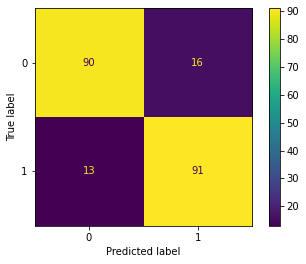

In [76]:
plot_confusion_matrix(classifier, X_test, y_test)
pyplot.show()

Métricas de validação:

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Acurácia

In [67]:
accuracy_score(y_test, y_pred)

0.861904761904762

### Precisão

In [68]:
precision_score(y_test, y_pred)

0.8504672897196262

### Recall

In [69]:
recall_score(y_test, y_pred)

0.875

### F1 Score

In [70]:
f1_score(y_test, y_pred)

0.8625592417061612